# MIOFlow

## Workflow
1. Load pre-processed SERGIO simulation AnnData
2. Train a **GAGA autoencoder** (`gaga.py`) — learns a geometry-preserving latent embedding from PCA, regularised by PHATE distances
3. Pass the trained GAGA model to `MIOFlow` and call `fit()` — trains a Neural ODE in GAGA latent space using optimal transport
4. Inspect losses and trajectories
5. `decode_to_gene_space()` — maps trajectories back through the GAGA decoder and PCA components to recover gene-level predictions

In [16]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sys.path.insert(0, '../MIOFlow')
from gaga import fit_gaga
from mioflow import MIOFlow


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Data

In [17]:
adata = sc.read_h5ad('data/sergio/SERGIO_sim_DS9.h5ad')
adata.obs['merged_pseudotime_bin'] = adata.obs['pseudotime_bin'].copy()
adata.obs['merged_pseudotime_bin'] = adata.obs['merged_pseudotime_bin'].replace({4:3, 5: 3, 6: 3, 7: 3})
adata.obs['merged_pseudotime_bin'] = adata.obs['merged_pseudotime_bin'].astype('category')
adata


AnnData object with n_obs × n_vars = 900 × 100
    obs: 'sim_time_bin', 'sim_timepoint', 'pseudotime', 'pseudotime_bin', 'merged_pseudotime_bin'
    uns: 'log1p', 'pca'
    obsm: 'X_pca', 'X_phate', 'X_phate_pca'
    varm: 'PCs'

In [18]:
adata.obs['merged_pseudotime_bin'].value_counts()

merged_pseudotime_bin
3    562
0    113
2    113
1    112
Name: count, dtype: int64

Set the time_column for your dataset

In [19]:
time_column = 'merged_pseudotime_bin' #Set the time_column for your dataset

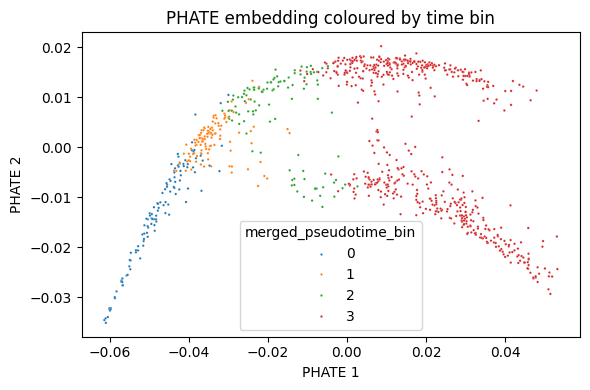

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    x=adata.obsm['X_phate'][:, 0],
    y=adata.obsm['X_phate'][:, 1],
    hue=adata.obs[time_column],
    palette='tab10',
    s=3,
    ax=ax,
)
ax.set_xlabel('PHATE 1')
ax.set_ylabel('PHATE 2')
ax.set_title('PHATE embedding coloured by time bin')
plt.tight_layout()
plt.show()

## 2. Train GAGA Autoencoder

GAGA (`gaga.py`) trains a two-phase autoencoder on PCA embeddings, regularised by PHATE distances:

- **Phase 1** — encoder learns a geometry-preserving latent space (distance preservation loss, decoder frozen)
- **Phase 2** — decoder learns to reconstruct PCA coordinates (reconstruction loss, encoder frozen)

The resulting latent space is where the MIOFlow ODE will be trained.

In [21]:
gaga_model = fit_gaga(
    X_pca      = adata.obsm['X_pca'],
    X_phate    = adata.obsm['X_phate'],
    latent_dim = 2,
    hidden_dims= [128, 64],
    batch_size = 1024,
    encoder_epochs=300,
    decoder_epochs=300,
    learning_rate=1e-3,
    dist_weight_phase1=1.0,
    recon_weight_phase2=1.0,
)

GAGA architecture: 30 → 2
Phase 1: Training encoder (decoder frozen) for distance preservation
Training GAGA on device: cpu
Encoder frozen: False, Decoder frozen: True
Reconstruction weight: 0.0, Distance weight: 1.0


Epochs: 100%|██████████| 300/300 [00:02<00:00, 109.15it/s, train_loss=0.0215, recon=1.0223, dist=0.0215]



Phase 2: Training decoder (encoder frozen) for reconstruction
Training GAGA on device: cpu
Encoder frozen: True, Decoder frozen: False
Reconstruction weight: 1.0, Distance weight: 0.0


Epochs: 100%|██████████| 300/300 [00:01<00:00, 197.39it/s, train_loss=0.8313, recon=0.8313, dist=0.0213]


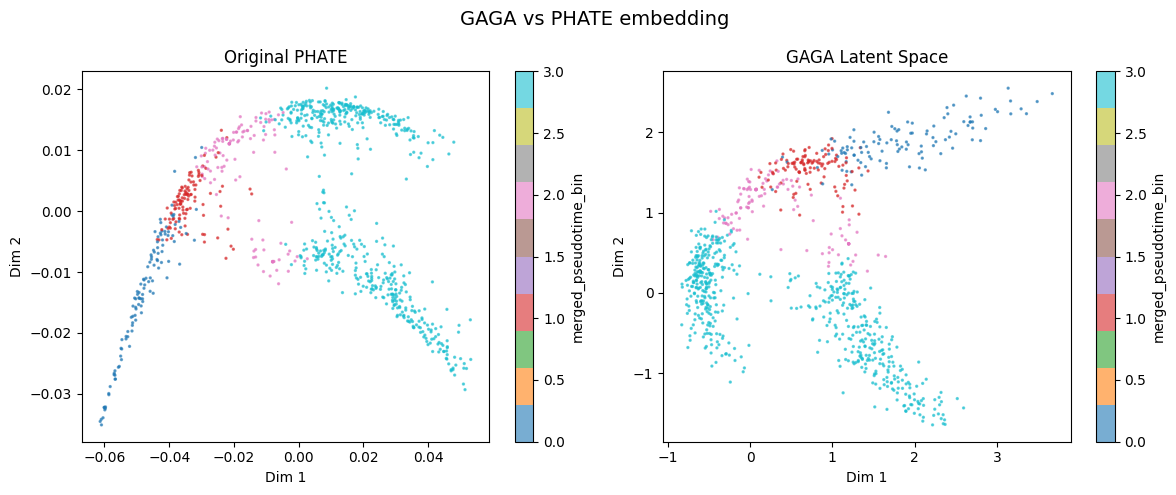

In [22]:
# quick sanity-check: compare GAGA latent space with original PHATE
X_pca_scaled = gaga_model.input_scaler.transform(adata.obsm['X_pca'].astype('float32'))
gaga_model.eval()
with torch.no_grad():
    gaga_embeddings = gaga_model.encode(torch.tensor(X_pca_scaled)).numpy()

adata.obsm['X_gaga'] = gaga_embeddings

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, key, title in zip(
    axes,
    ['X_phate', 'X_gaga'],
    ['Original PHATE', 'GAGA Latent Space'],
):
    sc_plot = ax.scatter(
        adata.obsm[key][:, 0], adata.obsm[key][:, 1],
        c=adata.obs[time_column], cmap='tab10', s=2, alpha=0.6,
    )
    plt.colorbar(sc_plot, ax=ax, label=time_column)
    ax.set_title(title)
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')

plt.suptitle('GAGA vs PHATE embedding', fontsize=14)
plt.tight_layout()
plt.show()


## 3. Configure and Initialise MIOFlow

Pass the trained `gaga_model` and `scaler_pca` (the scaler fitted on `X_pca` before GAGA training).  
`MIOFlow` will use the encoder to embed cells into latent space for ODE training, and the decoder in `decode_to_gene_space()`.

In [8]:
import importlib

sys.path.insert(0, '../MIOFlow')
import mioflow
# After making changes to my_module:
importlib.reload(mioflow)


mioflow_model = mioflow.MIOFlow(
    adata,
    gaga_model=gaga_model,
    obs_time_key=time_column,
    debug_level='info',
    #model
    hidden_dim = 64,
    use_cuda = torch.cuda.is_available(),
    use_sde = True,
    diffusion_scale = 0.1,
    diffusion_init_scale = 0.1,
    sde_dt = 0.1,
    lambda_energy_f = 1.0,
    lambda_energy_g = 0.0,
    grad_clip = 1.0,
    momentum_beta = 0.0,
    scheduler_type='cosine',
    learning_rate = 1e-3,
    scheduler_t_max=300,
    scheduler_min_lr=1e-5,
    # Training phases
    n_epochs=300,
    # Loss
    use_density_loss=True,
    lambda_ot = 1.0,
    lambda_density=0.0,
    lambda_energy=0.1,
    energy_time_steps=20,
    # Data / output
    sample_size=100,
    n_trajectories=100,
    n_bins=100,
    exp_dir='.',
)



2026-02-27 21:21:02,004 - MIOFlow - INFO - MIOFlow initialised | 900 cells, 100 genes | device=cpu


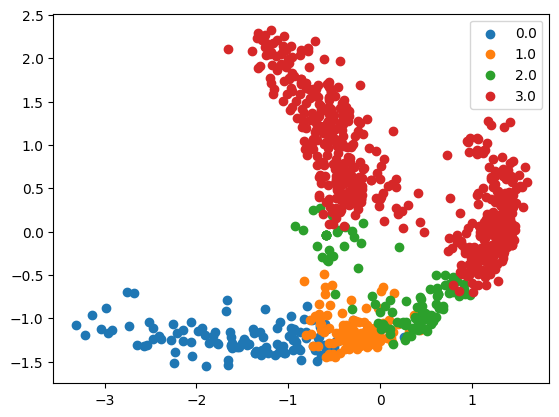

In [9]:
for data, i in mioflow_model.dataset.time_series_data:
    plt.scatter(data[:,0],data[:,1],label=i)
plt.legend()

## 4. Fit — `~5 minutes`

`fit()` runs three phases under the hood:
1. **Training** (`n_local_epochs`) — trains each consecutive time-point pair independently

The ODE operates entirely in the GAGA latent space.

In [10]:
mioflow_model.fit()
print(mioflow_model)

2026-02-27 21:21:03,850 - MIOFlow - INFO - SDEFunc: input_dim=2, hidden_dim=64
2026-02-27 21:21:03,850 - MIOFlow - INFO - Global training: 300 epochs
Training (global): 100%|██████████| 300/300 [00:47<00:00,  6.38it/s]
2026-02-27 21:21:50,910 - MIOFlow - INFO - Trajectories generated: shape=(100, 100, 2)
2026-02-27 21:21:50,911 - MIOFlow - INFO - MIOFlow fitting completed.


MIOFlow(n_obs=900, gaga=Autoencoder, n_epochs=300, trajectories=(100, 100, 2), status=fitted)


## 4. Training Losses

After fitting:
- `mf.losses` — list of dicts `{'Total', 'OT', 'Density', 'Energy'}` per epoch (local phase)

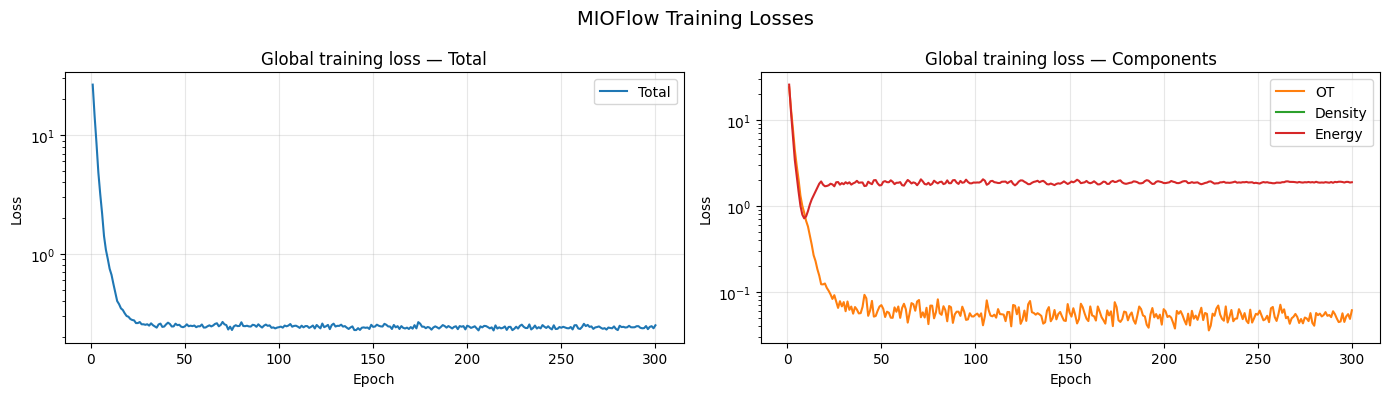

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ── Losses ───────────────────────────────────────────────────────────
epochs = mioflow_model.losses['epoch']

# Left: total loss
ax = axes[0]
ax.plot(epochs, mioflow_model.losses['total_loss'], label='Total', color='tab:blue')
ax.set_title('Global training loss — Total')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: individual loss components
ax = axes[1]
ax.plot(epochs, mioflow_model.losses['ot_loss'],      label='OT',      color='tab:orange')
ax.plot(epochs, mioflow_model.losses['density_loss'], label='Density', color='tab:green')
ax.plot(epochs, mioflow_model.losses['energy_loss'],  label='Energy',  color='tab:red')
ax.set_title('Global training loss — Components')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('MIOFlow Training Losses', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Trajectories in GAGA Latent Space

`mf.trajectories` has shape **`(n_bins, n_trajectories, latent_dim)`**.

To iterate over individual trajectories use `mf.trajectories[:, i, :]`.

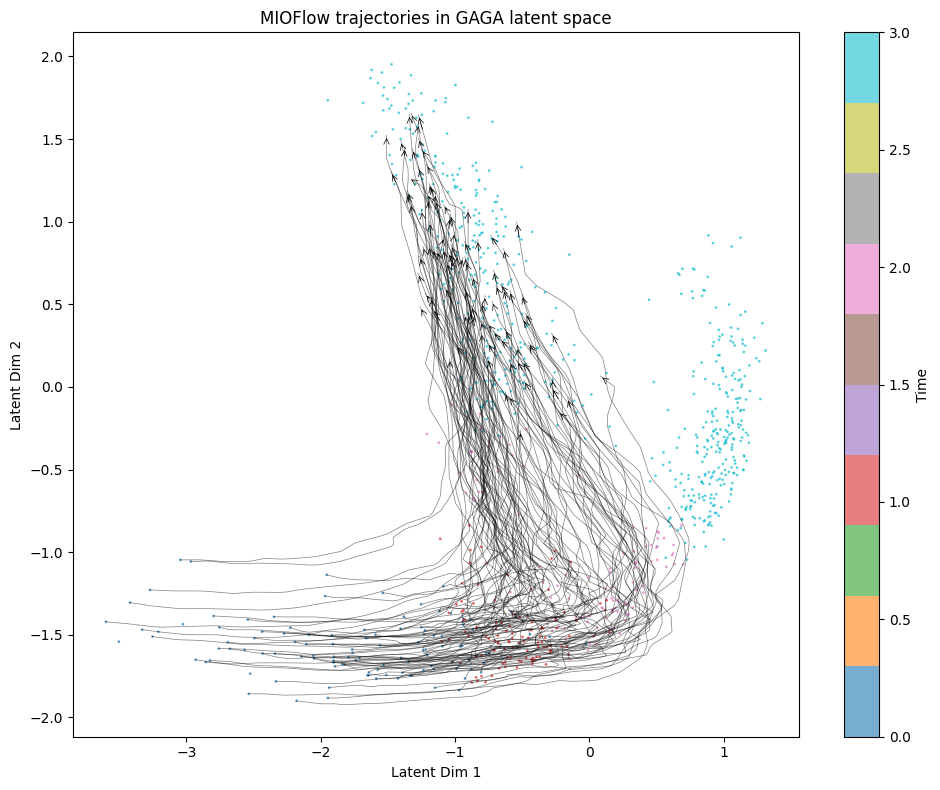

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sc_plot = ax.scatter(
    mioflow_model.embedding[:, 0], mioflow_model.embedding[:, 1],
    c=mioflow_model._time_labels, cmap='tab10', s=1, alpha=0.6,
)
plt.colorbar(sc_plot, ax=ax, label='Time')

for traj in mioflow_model.trajectories.transpose(1, 0, 2):  # (n_traj, n_bins, latent_dim)
    ax.plot(traj[:, 0], traj[:, 1], alpha=0.5, linewidth=0.5, color='black')
    ax.annotate(
        '', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
        arrowprops=dict(arrowstyle='->', color='black', lw=0.5, mutation_scale=10),
    )

ax.set_xlabel('Latent Dim 1')
ax.set_ylabel('Latent Dim 2')
ax.set_title('MIOFlow trajectories in GAGA latent space')
plt.tight_layout()
plt.show()


## 6. Decode to Gene Space

`decode_to_gene_space()` maps trajectories through the chain:

**GAGA latent → GAGA decoder → PCA space (inverse scaler) → gene space**

Returns shape **`(n_bins, n_trajectories, n_genes)`**.

In [13]:
trajectories_gene_space = mioflow_model.decode_to_gene_space()
print('Gene-space trajectory shape (n_bins, n_trajectories, n_genes):',
      trajectories_gene_space.shape)

Gene-space trajectory shape (n_bins, n_trajectories, n_genes): (100, 100, 100)


## 7. Gene Trends — Top Highly-Variable Genes

We plot the mean expression (± std) over all trajectories at each time bin.

In [14]:
sc.pp.highly_variable_genes(adata, n_top_genes=25)
example_genes     = adata.var_names[adata.var['highly_variable']]
example_gene_mask = adata.var_names.isin(example_genes)
print(example_genes)

Index(['G3', 'G6', 'G12', 'G14', 'G21', 'G25', 'G26', 'G31', 'G32', 'G33',
       'G36', 'G40', 'G49', 'G51', 'G59', 'G64', 'G65', 'G68', 'G69', 'G72',
       'G80', 'G88', 'G94', 'G95', 'G99'],
      dtype='object')


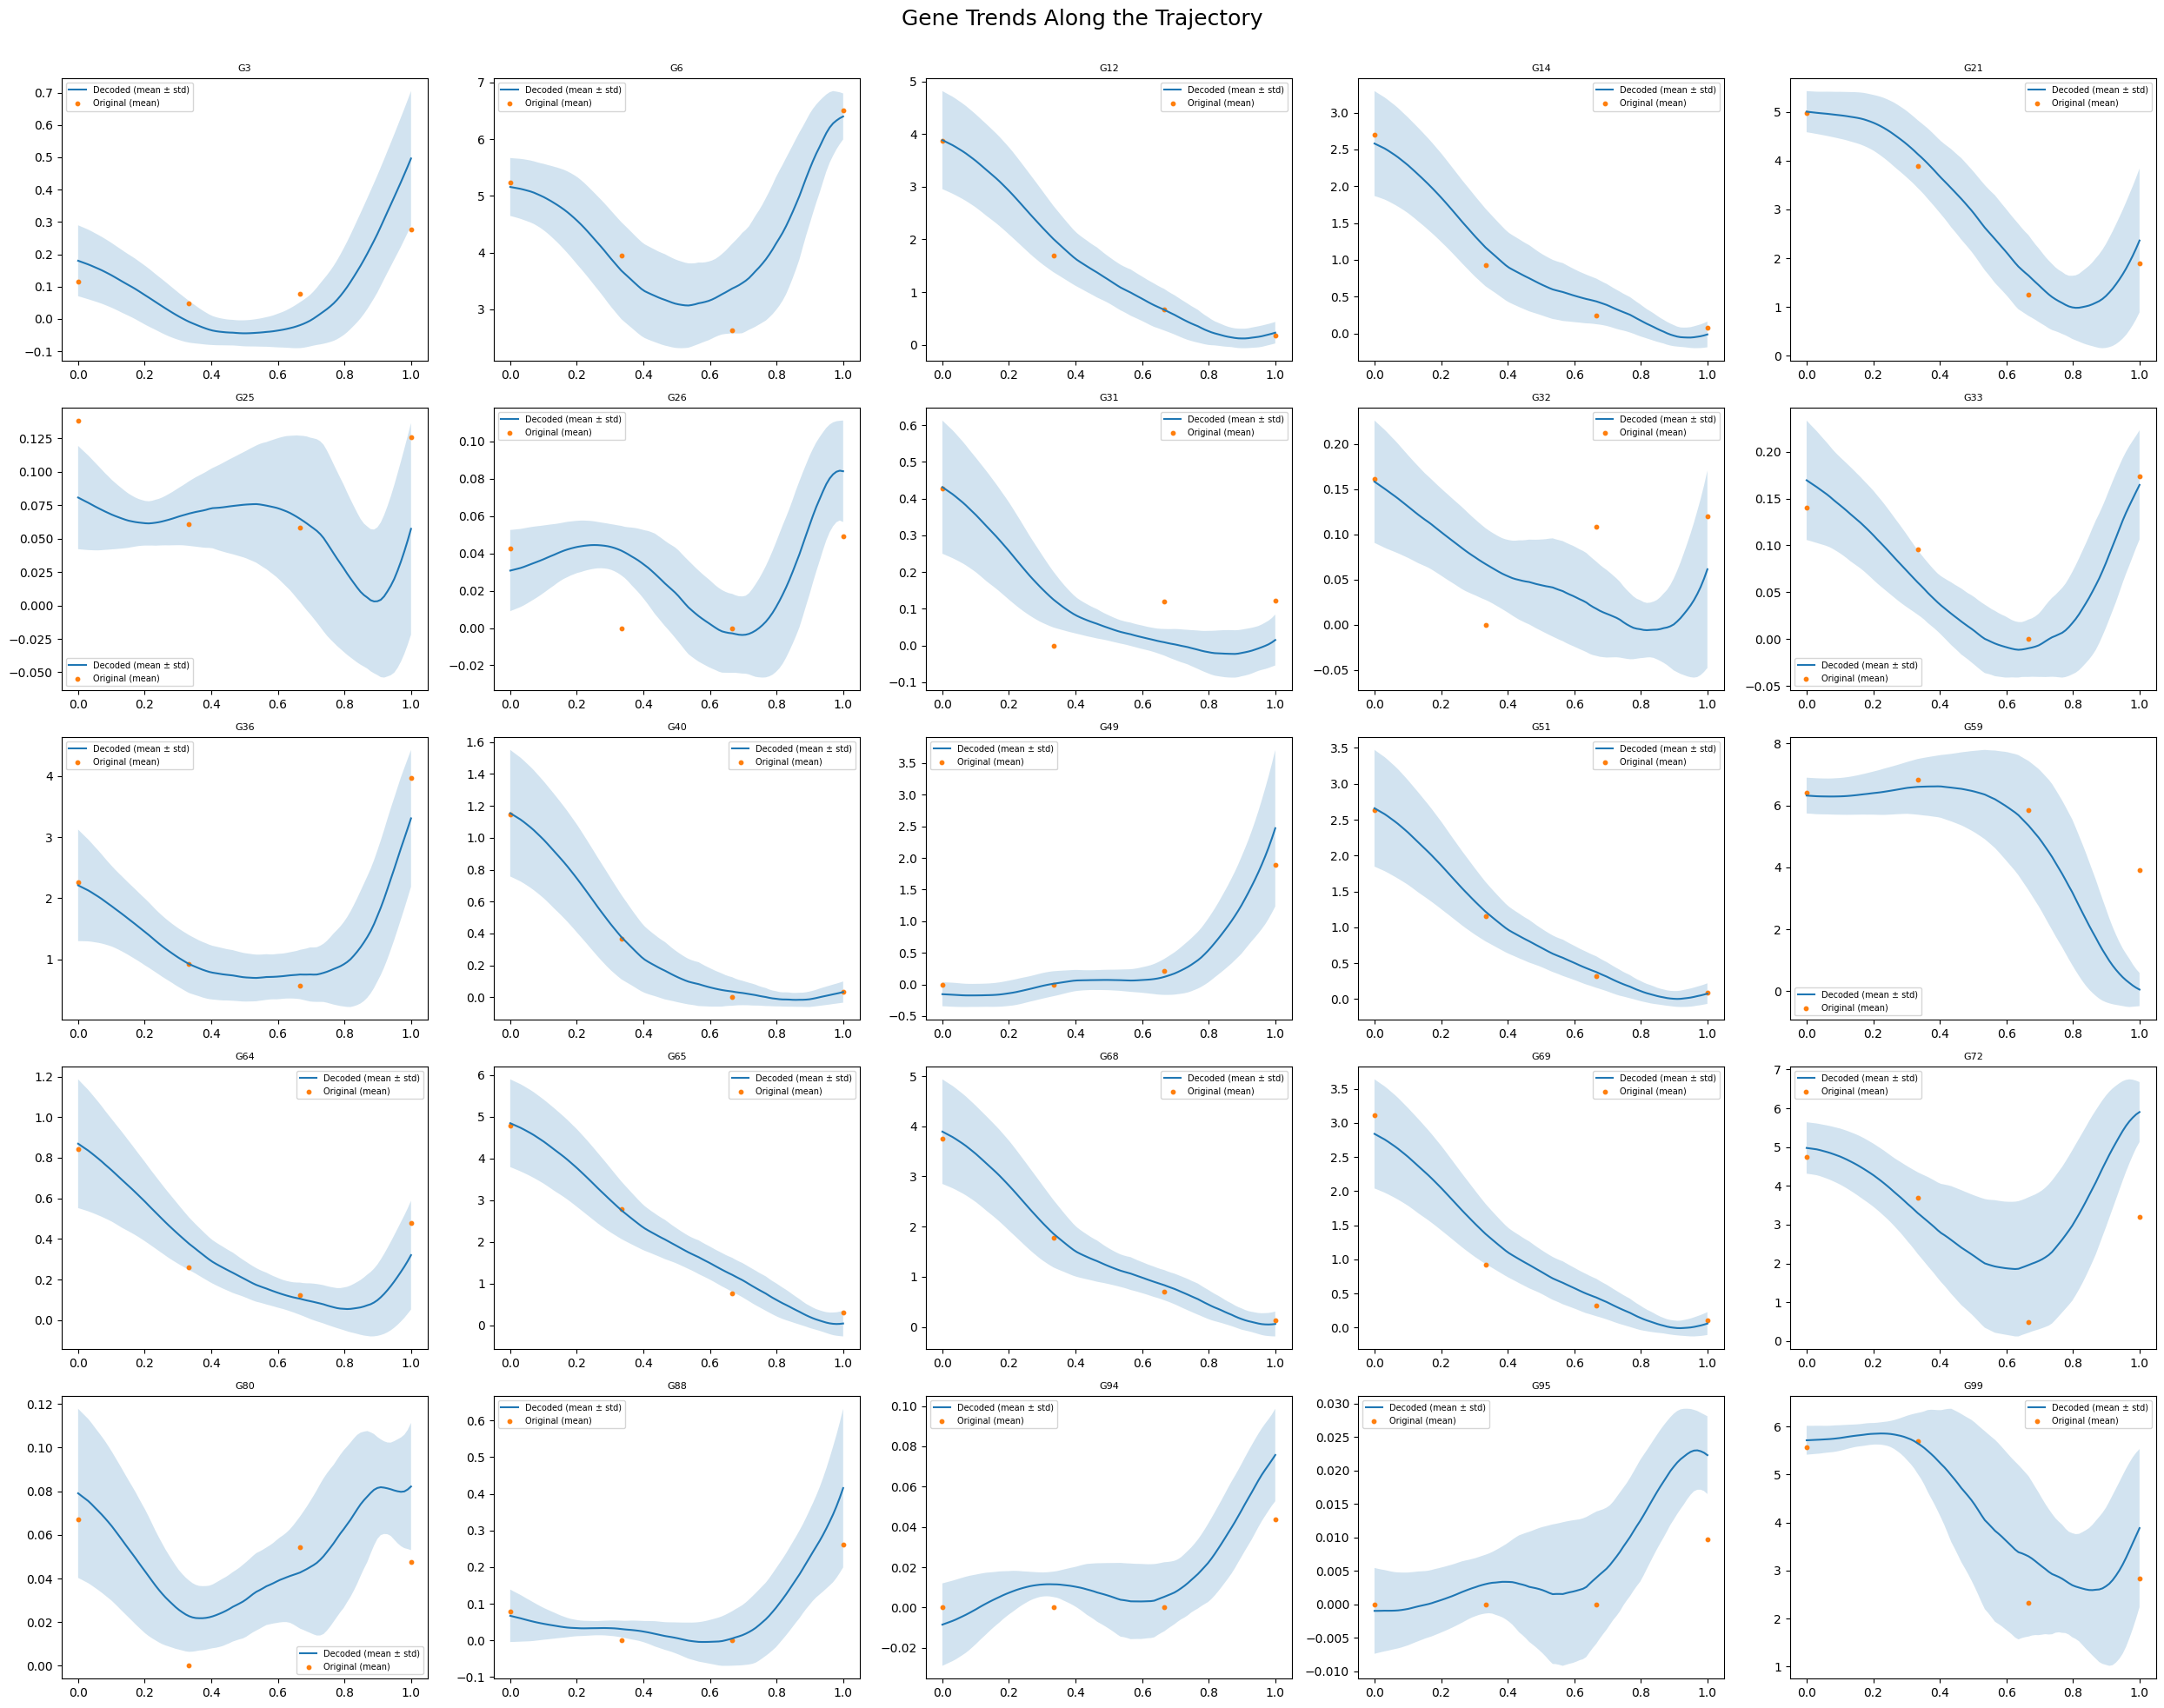

In [15]:
# decoded shape: (n_bins, n_trajectories, n_selected_genes)
decoded_example_gene = trajectories_gene_space[:, :, example_gene_mask]

# Mean / std over trajectories (axis=1) → (n_bins, n_selected_genes)
decoded_mean = decoded_example_gene.mean(axis=1)
decoded_std  = decoded_example_gene.std(axis=1)

# Normalised time axis
x_time = np.linspace(0, 1, decoded_mean.shape[0])

# Reconstruct integer time labels the same way MIOFlow does internally
t = mioflow_model._time_labels.astype(float)
obs_time_norm = (t - t.min()) / (t.max() - t.min())

# Original data aggregated by time
adata_sel = adata[:, example_gene_mask]
data_df   = pd.DataFrame(adata_sel.X.toarray(), columns=example_genes)
data_df['t'] = obs_time_norm
data_mean = data_df.groupby('t').mean()

# Grid plot
n_genes = decoded_mean.shape[1]
n_cols  = int(np.ceil(np.sqrt(n_genes)))
n_rows  = int(np.ceil(n_genes / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, gene in enumerate(example_genes):
    ax = axes[i]
    ax.plot(x_time, decoded_mean[:, i], label='Decoded (mean ± std)')
    ax.fill_between(x_time,
                    decoded_mean[:, i] - decoded_std[:, i],
                    decoded_mean[:, i] + decoded_std[:, i],
                    alpha=0.2)
    ax.scatter(data_mean.index, data_mean[gene], s=10, label='Original (mean)')
    ax.set_title(gene, fontsize=8)
    ax.legend(fontsize=7)

for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Gene Trends Along the Trajectory', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()
